In [12]:
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.image as img
from sklearn.preprocessing import normalize                           
import seaborn as sns
from numpy import linspace
import seaborn as sns
from cv2 import MORPH_ELLIPSE
import seaborn
from tqdm import tqdm 
from skimage.feature import graycomatrix, graycoprops
import random
import shutil

# CITOPLASMA

### PROCESAMIENTO DE LAS IMÁGENES DE ENTRADA

Se realiza el redimensionamiento de las imágenes del conjunto de datos

In [13]:
ancho = 128
alto = 128

In [14]:
dir = 'CELULAS/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
#recorrer cada una de las clases
clase = ['DatasetNormalizado/1_normal_superficiel/','DatasetNormalizado/2_normal_intermediate/','DatasetNormalizado/3_normal_columnar/','DatasetNormalizado/4_light_dysplastic/','DatasetNormalizado/5_moderate_dysplastic/','DatasetNormalizado/6_severe_dysplastic/','DatasetNormalizado/7_carcinoma_in_situ/']
#clase = ['DatasetNormalizado/1_normal_superficiel/','DatasetNormalizado/2_normal_intermediate/','DatasetNormalizado/6_severe_dysplastic/','DatasetNormalizado/7_carcinoma_in_situ/']
# redimensionamiento de cada celula
for grupo in tqdm(clase):
    listaCelula = os.listdir(grupo)
    for celda in (listaCelula):
        dir = grupo+celda
        imagen = cv2.imread(dir)
        #imagen = imagen[:,:,0]
        imagen = cv2.resize(imagen,dsize=(ancho,alto))
        #guardar en una sola carpeta todas las celulas
        cv2.imwrite('CELULAS/'+celda,imagen)

100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


### PROCESAMIENTO DE LAS IMAGENES DE REFERENCIA CITOPLASMA

Las imágenes de referencia contiene la información de la región de interés ya segmentada. Demarcada con una máscara, en este caso para el citoplasma

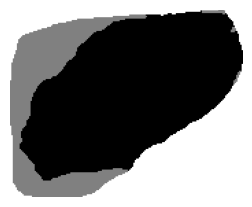

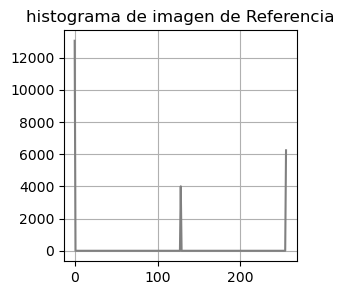

In [15]:
dir = 'DatasetNormalizado/MASCARAS/2_normal_intermediate/normalInter14.jpg'
# lectura de la imagen en formato BGR
citoplasma = cv2.imread(dir)
# plano de rojos
citoplasma = citoplasma[:,:,2]
plt.figure(figsize=(3,3))
plt.imshow(citoplasma,'gray')
plt.axis(False)
plt.show()

# histograma plano r
hist = cv2.calcHist([citoplasma],[0],None,[256],[0,256]);
plt.figure(figsize=(3,3))
plt.plot(hist,'gray')
plt.grid()
plt.title('histograma de imagen de Referencia')
plt.show()

(-0.5, 169.5, 136.5, -0.5)

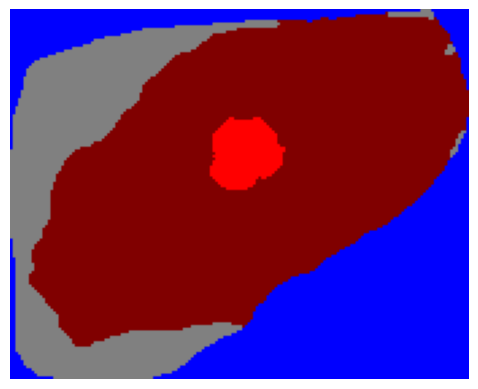

In [16]:
plt.imshow(cv2.imread(dir))
plt.axis(False)

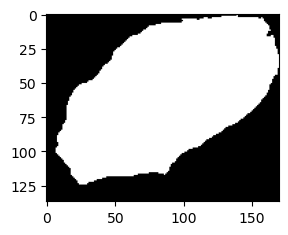

In [17]:
citoplasma[citoplasma >= 100] = 10
citoplasma[citoplasma != 10] = 255
#citoplasma = cv2.bitwise_not(citoplasma)
#citoplasma[citoplasma <= 10] = 255
plt.figure(figsize=(3,3))
plt.imshow(citoplasma,'gray')

dtype('uint8')

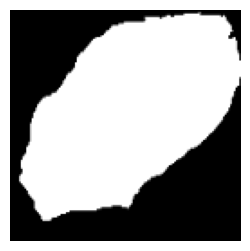

In [18]:
# redimensionamiento
citoplasma = cv2.resize(citoplasma,dsize=(ancho,alto))
#nucleo = np.asarray(nucleo,dtype=np.bool_)
plt.figure(figsize=(3,3))
plt.imshow(citoplasma,'gray')
plt.axis(False)
cv2.imwrite('borrar.jpg',citoplasma)
citoplasma.dtype

Procesamiento de las máscaras
A cada imagen de las máscara correspondiente, a partir del histograma de selecciona solo el color que corresponde con el citoplasma,  lo demás se deja como fondo. Cada imagen se guarda en la carpeta de máscara

In [20]:
dir = 'MASCARAS/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

clase = ['DatasetNormalizado/MASCARAS/1_normal_superficiel/','DatasetNormalizado/MASCARAS/2_normal_intermediate/','DatasetNormalizado/MASCARAS/3_normal_columnar/','DatasetNormalizado/MASCARAS/4_light_dysplastic/','DatasetNormalizado/MASCARAS/5_moderate_dysplastic/','DatasetNormalizado/MASCARAS/6_severe_dysplastic/','DatasetNormalizado/MASCARAS/7_carcinoma_in_situ/']
#clase = ['DatasetNormalizado/MASCARAS/1_normal_superficiel/']
#clase = ['DatasetNormalizado/MASCARAS/1_normal_superficiel/','DatasetNormalizado/MASCARAS/2_normal_intermediate/','DatasetNormalizado/MASCARAS/6_severe_dysplastic/','DatasetNormalizado/MASCARAS/7_carcinoma_in_situ/']
#redimensionsamiento de imagenes de referencia
for grupo in tqdm(clase):
    listaCelula = os.listdir(grupo)
    for celda in (listaCelula):
        dir = grupo+celda
        citoplasma = cv2.imread(dir)
        citoplasma = citoplasma[:,:,2]
        citoplasma[citoplasma >= 100] = 10
        citoplasma[citoplasma != 10] = 255
        citoplasma = cv2.resize(citoplasma,dsize=(ancho,alto))
        #imagen = np.asarray(imagen,dtype=np.bool_)
        cv2.imwrite('MASCARAS/'+celda,citoplasma)

100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


## DATA AUGMENTATION

El aumento de los datos se hace para las primeras dos clases: normal Superficial, normal Intermedia, normal Columnar. A cada una de las imágenes correspondiente se les hace una rotacion de 90 °

In [21]:
# se toma la lista de todas las celulas dentro de la Carpeta de entrenamiento que coinciden con el nombre de su máscara
listaRot = os.listdir('CELULAS/')
numF = len(listaRot)
# se filtran las tres primeras clases normal Superficial(normalSup#), 
# normal Intermediate(normalInter#), normal Columnar(normalCol#)
for iter in listaRot:
    if iter[:6] == 'normal':
        numF +=1
        #leer las imagen su correspondiente imagen
        imagen = cv2.imread('CELULAS/'+iter)
        imagenMasc = cv2.imread('MASCARAS/'+iter)
        #aplicar un giro de 90°
        imagen = cv2.rotate(imagen,cv2.ROTATE_90_CLOCKWISE)
        imagenMasc = cv2.rotate(imagenMasc,cv2.ROTATE_90_CLOCKWISE)

        #nombrar y expotar
        if iter[6:9] == 'Col':
            nombre = 'normalCol'+str(numF)

        elif iter[6:9] == 'Sup':
            nombre = 'normalSup'+str(numF)

        elif iter[6:11] == 'Inter':
            nombre = 'normalInter'+str(numF)

        cv2.imwrite('CELULAS/'+nombre+'.jpg',imagen)
        cv2.imwrite('MASCARAS/'+nombre+'.jpg',imagenMasc)

### CREACION DEL CONJUNTO DE DATOS DE PRUEBA 

Se selecciona de forma aleatoria imágenes del conjunto de datos de entrenamiento

In [22]:
dir = 'PRUEBA/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

listaCelula = os.listdir('CELULAS/')
listaMascara = os.listdir('MASCARAS/')

porc = round(len(listaCelula)*0.2)
for iter  in range(0,porc):
    img = random.choice(listaCelula)
    file_oldname = os.path.join('CELULAS/'+img)
    file_newname_newfile = os.path.join('PRUEBA/'+img)
    os.rename(file_oldname, file_newname_newfile)
    os.remove('MASCARAS/'+img)
    listaCelula.remove(img)

In [24]:
coincidencias = 0
celula = os.listdir('CELULAS/')
mascara = os.listdir('MASCARAS/')
prueba = os.listdir('PRUEBA/')
for i,e in enumerate(celula):
    for r,t in enumerate(prueba):
        if e==t:
            coincidencias +=1
print('coincidencias: ',coincidencias)

coincidencias:  0
